In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# 데이터 불러오기

In [2]:
# 데이터 로딩
train_X_data = pd.read_csv('./train_set/train_X_data.csv', index_col='datetime', parse_dates=True)
test_X_data = pd.read_csv('./test_set/test_X_data.csv', index_col='datetime', parse_dates=True)
train_Y_data = pd.read_csv('./train_set/train_Y_data.csv', index_col='datetime', parse_dates=True)
test_Y_data = pd.read_csv('./test_set/test_Y_data.csv', index_col='datetime', parse_dates=True)


# X 데이터의 모든 열을 숫자형으로 변환
# apply(pd.to_numeric, errors='coerce')를 사용하면 변환되지 않는 값이 NaN으로 변환
train_X_data = train_X_data.apply(pd.to_numeric, errors='coerce') 
test_X_data = test_X_data.apply(pd.to_numeric, errors='coerce')

# 타겟 변수의 'Kp' 열을 숫자형으로 변환
train_Y_data['Kp'] = pd.to_numeric(train_Y_data['Kp'], errors='coerce')
test_Y_data['Kp'] = pd.to_numeric(test_Y_data['Kp'], errors='coerce')

# print(train_X_data.head)
# print(train_Y_data.head)

# Random Forest Regressor

### RF Model 생성

In [3]:
# 랜덤 포레스트 회귀 모델 초기화
rf_regressor = RandomForestRegressor(random_state=42)

In [4]:
num_features = train_X_data.shape[1]
max_features_value = int(num_features / 3)

### 하이퍼 파라미터 튜닝, 모델 학습

1차 하이퍼 파라미터 튜닝

'n_estimators': [700, 1000, 1200]

'max_depth': [20, 30, 40]

'min_samples_split': [5, 10, 15]

'min_samples_leaf': [2, 5, 10]

Best Parameters: {'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 15, 'n_estimators': 700}

Test WRMSE: 0.7180593609809875

2차 하이퍼 파라미터 튜닝

'n_estimators': [500, 700]

'max_depth': [15, 20]

'min_samples_split': [15, 20]

'min_samples_leaf': [5]

Best Parameters: {'max_depth': 15, 'min_samples_leaf': 5, 'min_samples_split': 15, 'n_estimators': 700}

Test WRMSE: 0.7180593609809875

In [6]:
# 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [700], #랜덤 포레스트 안의 결정 트리 수
    'max_features': [max_features_value], #각 트리를 분할할 때 고려할 최대 특징 수 ('sqrt'는 모든 특징의 제곱근을 의미)
    'max_depth': [15], #각 결정 트리의 최대 깊이

    'min_samples_split': [15], #내부 노드를 분할하기 위한 최소 샘플 수
    # 이 파라미터는 노드를 분할하기 위해 필요한 최소 샘플 수를 지정합니다. 
    # 예를 들어, min_samples_split=10으로 설정하면, 
    # 어떤 노드가 10개 이상의 샘플을 포함하지 않으면 더 이상 분할되지 않습니다. 
    # 이는 과적합(overfitting)을 방지하는 데 도움이 됩니다.

    'min_samples_leaf': [5], #리프 노드에 있어야 할 최소 샘플 수
    # 이 파라미터는 리프 노드가 최소 몇 개의 샘플을 가져야 하는지를 지정합니다. 
    # 예를 들어, min_samples_leaf=5로 설정하면, 
    # 어떤 리프 노드도 5개 미만의 샘플을 가질 수 없습니다. 
    # 이는 모델의 일반화 성능을 향상시키는 데 도움이 됩니다.

}

### 튜닝 및 학습

In [7]:
# TimeSeriesSplit 객체 생성
# 첫 번째 폴드에서는 처음 10%의 데이터를 학습 셋으로 사용하고, 그 다음 10%를 검증 셋으로 사용합니다.
# 두 번째 폴드에서는 처음 20%의 데이터를 학습 셋으로 사용하고, 그 다음 10%를 검증 셋으로 사용합니다.
# 이러한 방식으로 마지막 폴드까지 진행됩니다.
tscv = TimeSeriesSplit(n_splits=7)

# GridSearchCV를 사용하여 최적의 하이퍼파라미터 찾기.
# verbose: 출력 메시지 수준.
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, 
                           cv=tscv, verbose=2, n_jobs=-1)

#모델 학습
grid_search.fit(train_X_data, train_Y_data['Kp'])  # 타겟 변수 'Kp' 사용

# 최적의 하이퍼파라미터 출력
print(f"Best Parameters: {grid_search.best_params_}")

Fitting 7 folds for each of 1 candidates, totalling 7 fits
[CV] END max_depth=15, max_features=11, min_samples_leaf=5, min_samples_split=15, n_estimators=700; total time=  17.6s
[CV] END max_depth=15, max_features=11, min_samples_leaf=5, min_samples_split=15, n_estimators=700; total time=  40.3s
[CV] END max_depth=15, max_features=11, min_samples_leaf=5, min_samples_split=15, n_estimators=700; total time= 1.0min
[CV] END max_depth=15, max_features=11, min_samples_leaf=5, min_samples_split=15, n_estimators=700; total time= 1.4min
[CV] END max_depth=15, max_features=11, min_samples_leaf=5, min_samples_split=15, n_estimators=700; total time= 1.8min
[CV] END max_depth=15, max_features=11, min_samples_leaf=5, min_samples_split=15, n_estimators=700; total time= 2.1min
[CV] END max_depth=15, max_features=11, min_samples_leaf=5, min_samples_split=15, n_estimators=700; total time= 2.4min
Best Parameters: {'max_depth': 15, 'max_features': 11, 'min_samples_leaf': 5, 'min_samples_split': 15, 'n_es

### Prediction

In [8]:
# 최적의 모델로 예측 수행
best_model = grid_search.best_estimator_
y_pred = best_model.predict(test_X_data)

In [9]:
y_pred_df = pd.DataFrame(y_pred, index=test_Y_data.index, columns=['Prediction'])
y_pred_df.to_csv('./Prediction/RF_Regressor_Performance.csv')

### Accuracy

In [10]:
# WRMSE 함수 정의
def WRMSE(predictions, answers):
    sum_answer = answers.sum().item()  # DataFrame에서 직접 합 계산
    if sum_answer == 0:
        return torch.sqrt(torch.tensor(0.001, dtype=torch.float))
    weights = answers / sum_answer  # 각 값에 대해 가중치 계산
    loss = (weights * (predictions - answers).pow(2)).sum().item()  # 가중치 적용한 오차 제곱합
    return torch.sqrt(torch.tensor(loss, dtype=torch.float))

In [11]:
test_rmse = np.sqrt(mean_squared_error(test_Y_data, y_pred))

print(f'Test RMSE: {test_rmse}')

# 텐서 변환
test_targets_tensor = torch.tensor(test_Y_data['Kp'].values, dtype=torch.float32)
test_predictions_tensor = torch.tensor(y_pred_df['Prediction'].values, dtype=torch.float32)

# WRMSE 계산
wrmse_value = WRMSE(test_predictions_tensor, test_targets_tensor)
print(f'Test WRMSE: {wrmse_value.item()}')

Test RMSE: 0.6691091696346494
Test WRMSE: 0.7177360653877258


### 시각화

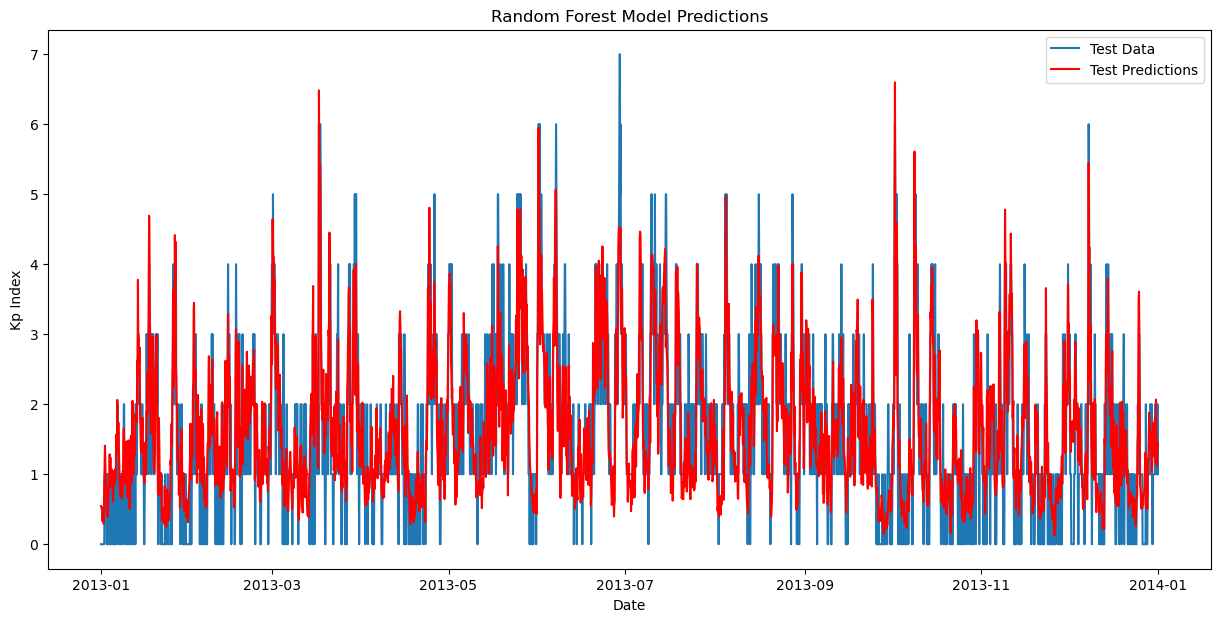

In [12]:
plt.figure(figsize=(15, 7))
plt.plot(test_Y_data, label='Test Data')
plt.plot(y_pred_df, label='Test Predictions', color='red')
plt.title('Random Forest Model Predictions')
plt.xlabel('Date')
plt.ylabel('Kp Index')
plt.legend()
plt.show()

### 중요 변수 확인

In [13]:
# 중요 변수 확인
feature_importances = best_model.feature_importances_
features = train_X_data.columns

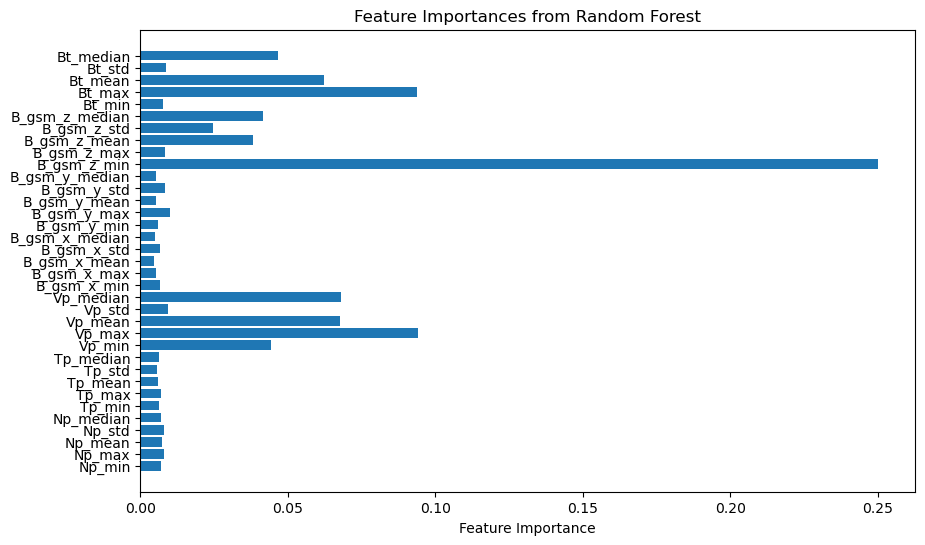

In [14]:
# 중요 변수 시각화
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importances from Random Forest')
plt.show()

# Random Forest Classifier

### RF Model 생성

In [15]:
# 랜덤 포레스트 분류 모델 초기화
rf_classifier = RandomForestClassifier(random_state=42)

### 하이퍼 파라미터 튜닝, 모델 학습

1차 하이퍼 파라미터 튜닝

'n_estimators': [500, 700, 1000]

'max_depth': [15, 20, 30]

'min_samples_split': [10, 15, 20]

'min_samples_leaf': [3, 5, 7]

Best Parameters: {'max_depth': 30, 'min_samples_leaf': 7, 'min_samples_split': 10, 'n_estimators': 1000}

Test WRMSE: 0.822329580783844

In [16]:
# 하이퍼파라미터 그리드 정의
param_grid = {
    'n_estimators': [1000], #랜덤 포레스트 안의 결정 트리 수
    'max_features': ['sqrt'], #각 트리를 분할할 때 고려할 최대 특징 수 ('sqrt'는 모든 특징의 제곱근을 의미)
    'max_depth': [30], #각 결정 트리의 최대 깊이
    'min_samples_split': [10], #내부 노드를 분할하기 위한 최소 샘플 수
    'min_samples_leaf': [7], #리프 노드에 있어야 할 최소 샘플 수
}

In [17]:
# GridSearchCV를 사용하여 최적의 하이퍼파라미터 찾기.
# verbose: 출력 메시지 수준.
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, 
                           cv=tscv, verbose=2, n_jobs=-1)

#모델 학습
grid_search.fit(train_X_data, train_Y_data['Kp'])  # 타겟 변수 'Kp' 사용

# 최적의 하이퍼파라미터 출력
print(f"Best Parameters: {grid_search.best_params_}")

Fitting 7 folds for each of 1 candidates, totalling 7 fits
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=7, min_samples_split=10, n_estimators=1000; total time=  15.4s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=7, min_samples_split=10, n_estimators=1000; total time=  34.9s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=7, min_samples_split=10, n_estimators=1000; total time=  53.6s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=7, min_samples_split=10, n_estimators=1000; total time= 1.2min
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=7, min_samples_split=10, n_estimators=1000; total time= 1.5min
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=7, min_samples_split=10, n_estimators=1000; total time= 1.8min
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=7, min_samples_split=10, n_estimators=1000; total time= 2.1min
Best Parameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_

### Prediction

In [18]:
# 최적의 모델로 예측 수행
best_model = grid_search.best_estimator_
y_pred = best_model.predict(test_X_data)

In [19]:
y_pred_df = pd.DataFrame(y_pred, index=test_Y_data.index, columns=['Prediction'])
y_pred_df.to_csv('./Prediction/RF_Classifier_Performance.csv')

### Accuracy

In [20]:
test_rmse = np.sqrt(mean_squared_error(test_Y_data, y_pred))

print(f'Test RMSE: {test_rmse}')

# 텐서 변환
test_targets_tensor = torch.tensor(test_Y_data['Kp'].values, dtype=torch.float32)
test_predictions_tensor = torch.tensor(y_pred_df['Prediction'].values, dtype=torch.float32)

# WRMSE 계산
wrmse_value = WRMSE(test_predictions_tensor, test_targets_tensor)
print(f'Test WRMSE: {wrmse_value.item()}')

Test RMSE: 0.7482857120440795
Test WRMSE: 0.8022516369819641


### 시각화

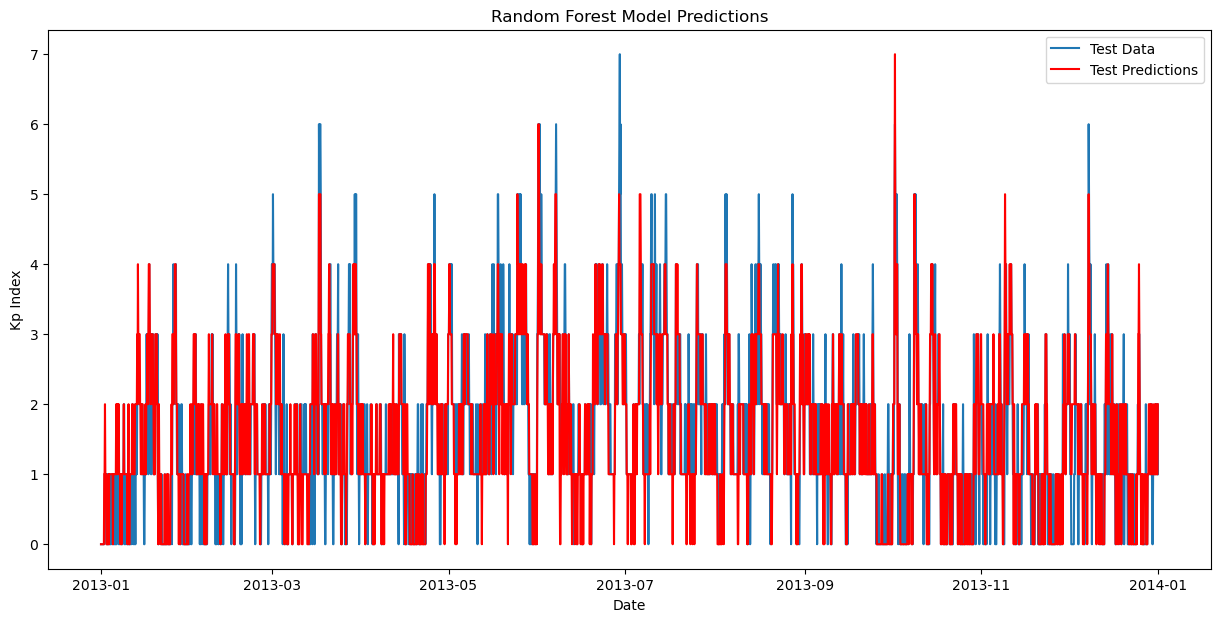

In [21]:
plt.figure(figsize=(15, 7))
plt.plot(test_Y_data, label='Test Data')
plt.plot(y_pred_df, label='Test Predictions', color='red')
plt.title('Random Forest Model Predictions')
plt.xlabel('Date')
plt.ylabel('Kp Index')
plt.legend()
plt.show()

### 중요 변수 확인

In [22]:
# 중요 변수 확인
feature_importances = best_model.feature_importances_
features = train_X_data.columns

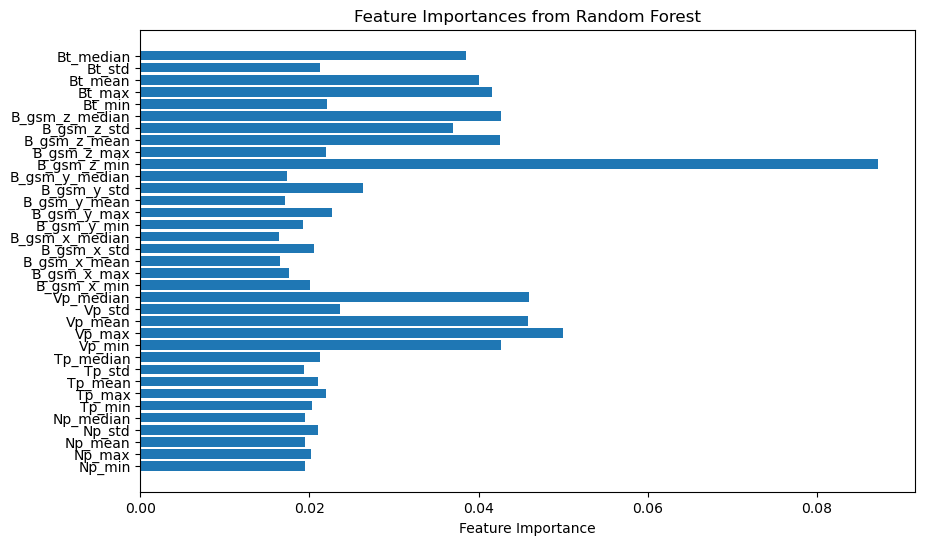

In [23]:
# 중요 변수 시각화
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importances from Random Forest')
plt.show()